# Đồ án nhận dạng tin giả bằng mô hình hybrid CNN + LSTM 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.metrics import Precision, Recall
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import re

In [2]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=Warning, module="tensorflow")

## Data description:
**Bộ dữ liệu được lấy từ nguồn:** https://www.kaggle.com/competitions/fake-news/overview
***
Dataset trong file **train.csv** và **test.csv** có 4 đặc trưng là:
- `title` : Tựa đề của bài báo.
- `author`: Tên tác giả.
- `text`  : Nội dung bài báo.
- `label` : Tính đáng tin cậy.
***
đặc trưng `label` đóng vai trò là target của mô hình dự đoán. Đặc trưng này mang 2 giá trị biểu diễn độ đáng tin cậy của bài báo:
* 1: không đáng tin
* 0: đáng tin
***

In [3]:
Data = pd.read_csv('train.csv', index_col='id')
features = Data.columns.to_list()[:-1]
print(Data.shape)
print(features)

(20800, 4)
['title', 'author', 'text']


Bộ dữ liệu có 20800 instances

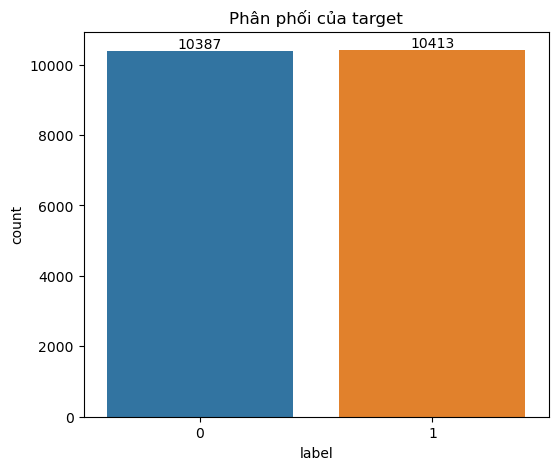

In [4]:
def plot_target(data, title):
    target_counts = data.value_counts('label')
    plt.figure(figsize=(6,5))
    ax = sns.barplot(x=target_counts.index, y=target_counts)
    ax.set_title(title)
    for i in ax.containers:
        ax.bar_label(i,)
plot_target(Data, 'Phân phối của target')

*&rarr; Bộ dữ liệu có target là một giá trị nhị phân với phân phối cân bằng.*

## Text preprocessing

* Xem qua một vài instace để có một cái nhìn cơ bản về dataset

In [5]:
Data.head(10)

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0


In [6]:
print("Missing values counter on Data")
for col in Data.columns:
    print(f"{col:<20}  {np.sum(pd.isnull(Data[col]))}")

Missing values counter on Data
title                 558
author                1957
text                  39
label                 0


Ta nhận thấy một số điểm sau:
- Đặc trưng `author` có một số giá trị bị thiếu. Đối với xử lý ngôn ngữ tự nhiên, ta có thể mặc định đây là những ký tự trống (''). 
   >Tuy nhiên, xét trên ngữ cảnh của bài toán phân loại tin giả, mối tương quan giữa việc không biết rõ tác giả với tính xác thực của bài báo là đáng quan tâm. <br>
&rarr;Vậy nên, ta cần quan sát thêm về mối tương quan giữa những giá trị bị thiếu này (`author`) đối với đặc trưng `target`.
- Bộ dữ liệu chứa nhiều ký tự đặc biệt không có ích cho quá trình dự đoán như `./>-` cần phải được loại bỏ.
- Các chữ cái viết hoa và viết thường không khác biệt nhau về nghĩa.

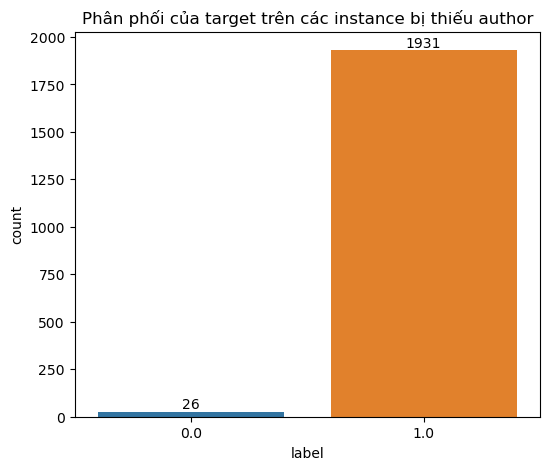

In [7]:
# đánh giá về phân bố của những instance có đặc trưng author bị thiếu.
observe_data = Data.where(Data['author'].isnull())
plot_target(observe_data, 'Phân phối của target trên các instance bị thiếu author')

&rarr; Vậy là luận điểm của em đã phần nào được chứng minh khi gần như toàn bộ những bài báo không rõ tác giả đều không đáng tin cậy. Dựa trên kinh nghiệm của bản thân, em sẽ impute những giá trị thiếu ở đặc trưng author là ***anonymousauthor*** để đảm bảo chúng được mô hình xem xét như một từ độc lập.

### Text cleaning

**1. Cài đặt những hàm làm sạch dữ liệu**

In [8]:
# Cài đặt một hàm để xử lý dữ liệu bị thiếu.
def handle_missing_values(data):
    newdata = pd.DataFrame()
    newdata['author'] = data['author'].fillna('anonymousauthor')
    cols = ['title', 'text']
    for i in cols:
        newdata[i] = data[i].fillna('')
    return newdata
        
# Cài đặt một hàm để đưa các chữ cái trong dữ liệu về chung dạng viết thường.
def lowcase_data(data):
    newdata = data.copy()
    for col in features:
        newdata[col] = data[col].str.lower()
    return newdata

# Cài đặt một hàm để loại bỏ những ký tự không phải chữ cái.
def remove_punctuations(text):
    x = re.sub(r'[^a-z ]', '',text)
    return ''.join(x)

- Xử lý missing values

In [9]:
cleaned_data = handle_missing_values(Data)
# gán lại Target cho tập train.
cleaned_data['label'] = Data['label']

In [10]:
print("Missing values counter on data")
for col in cleaned_data.columns:
    print(f"{col:<20}  {np.sum(pd.isnull(cleaned_data[col]))}")

Missing values counter on data
author                0
title                 0
text                  0
label                 0


- Xử lý chữ hoa.

In [11]:
cleaned_data = lowcase_data(cleaned_data)

- Xử lý dấu câu.

In [12]:
for col in features:
    cleaned_data[col] = cleaned_data[col].apply(remove_punctuations)

- merge text

In [13]:
cleaned_data.head(10)

,author,title,text,label
id,,,,
0,darrell lucus,house dem aide we didnt even see comeys letter...,house dem aide we didnt even see comeys letter...,1
1,daniel j flynn,flynn hillary clinton big woman on campus bre...,ever get the feeling your life circles the rou...,0
2,consortiumnewscom,why the truth might get you fired,why the truth might get you fired october th...,1
3,jessica purkiss,civilians killed in single us airstrike have ...,videos civilians killed in single us airstrik...,1
4,howard portnoy,iranian woman jailed for fictional unpublished...,print an iranian woman has been sentenced to s...,1
5,daniel nussbaum,jackie mason hollywood would love trump if he ...,in these trying times jackie mason is the voic...,0
6,anonymousauthor,life life of luxury elton johns favorite shar...,ever wonder how britains most iconic pop piani...,1
7,alissa j rubin,benot hamon wins french socialist partys presi...,paris france chose an idealistic tradition...,0
8,anonymousauthor,excerpts from a draft script for donald trumps...,donald j trump is scheduled to make a highly a...,0


*Vì mục tiêu của ta là sử dụng cả 3 đặc trưng của dữ liệu nhằm dự đoán, ta sẽ gộp chúng lại với nhau để tiện xử lý hơn*

In [14]:
Data_ = cleaned_data['author'] + ' ' + cleaned_data['title'] + ' ' + cleaned_data['text']
target = cleaned_data['label']

**2. Loại bỏ stopwords**
 
>Stopwords là những từ thường xuyên xuất hiện nhưng lại không có nhiều giá trị khi phân tích vì chúng thường mang ý chung chung, không nhấn mạnh cụ thể ý nghĩa của câu. Việc loại bỏ chúng sẽ giúp làm giảm chiều dữ liệu và giúp mô hình tập trung hơn vào những từ quan trọng.

- Ta sẽ sử dụng thư viện nltk để hỗ trợ.

In [15]:
import nltk
from nltk.corpus import stopwords

In [16]:
st_words = stopwords.words('english')
print(st_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

*Như đã thấy, tập các stopwords của **nltk** chứa những ký tự `'` thứ đã được loại bỏ ở các bước phía trên. Thế nên, tập stopwords cũng cần được xử lý tương tự để phát huy hiệu quả.*

In [17]:
st_words = [remove_punctuations(x) for x in st_words]

# Hàm để loại bỏ stopwords 
set_sw = set(st_words)
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in set_sw]
    return ' '.join(words)
Data_ = Data_.apply(remove_stopwords)

In [18]:
Data_.iloc[0]

'darrell lucus house dem aide even see comeys letter jason chaffetz tweeted house dem aide even see comeys letter jason chaffetz tweeted darrell lucus october subscribe jason chaffetz stump american fork utah image courtesy michael jolley available creative commonsby license apologies keith olbermann doubt worst person world weekfbi director james comey according house democratic aide looks like also know secondworst person well turns comey sent nowinfamous letter announcing fbi looking emails may related hillary clintons email server ranking democrats relevant committees hear comey found via tweet one republican committee chairmen know comey notified republican chairmen democratic ranking members house intelligence judiciary oversight committees agency reviewing emails recently discovered order see contained classified information long letter went oversight committee chairman jason chaffetz set political world ablaze tweet fbi dir informed fbi learned existence emails appear pertinent

**3. Lemmatizing words**

*Đây là phương pháp đưa các từ về dạng nguyên bản của nó (ví dụ như use - used - usefull) nhằm tăng lượng thông tin có trong mỗi từ và giảm tải không gian đặc trưng.*

In [19]:
from nltk.stem import WordNetLemmatizer

In [20]:
def lemmatize_text(text):
    lematizer = WordNetLemmatizer()
    words = text.split()
    words = [lematizer.lemmatize(word) for word in words]
    return ' '.join(words)
Data_ = Data_.apply(lemmatize_text)

In [21]:
Data_.iloc[0]

'darrell lucus house dem aide even see comeys letter jason chaffetz tweeted house dem aide even see comeys letter jason chaffetz tweeted darrell lucus october subscribe jason chaffetz stump american fork utah image courtesy michael jolley available creative commonsby license apology keith olbermann doubt worst person world weekfbi director james comey according house democratic aide look like also know secondworst person well turn comey sent nowinfamous letter announcing fbi looking email may related hillary clinton email server ranking democrat relevant committee hear comey found via tweet one republican committee chairman know comey notified republican chairman democratic ranking member house intelligence judiciary oversight committee agency reviewing email recently discovered order see contained classified information long letter went oversight committee chairman jason chaffetz set political world ablaze tweet fbi dir informed fbi learned existence email appear pertinent investigati

### Data Preparation

- Ở bước này ta sẽ thực hiện phân chia dữ liệu thành các tập train và valid để chuẩn bị huấn luyện mô hình. Ta sẽ sử dụng một tỉ lệ train | set thông dụ là 80% | 20%. Sau đó, ta sẽ lấy 20% của 80% vừa chia cho tập train để dùng làm tập validation.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
X_temp, X_test, y_temp, y_test = train_test_split(Data_, target, test_size=0.2, random_state=63)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, random_state=2002)

### Feature Selection

**Vì máy tính không thể đọc hiểu được ngôn ngữ con người, chúng ta sẽ cần phải mã hóa nó thành những con số mà máy tính đọc được. Một số phương pháp thường được sử dụng là TF-IDF, N-Gram, CountVector,...**

* Vector hóa dữ liệu bằng TF-IDF

</br>
Để tránh rò rỉ dữ liệu (data leakage), luôn phải ghi nhớ không fit hàm vector hóa trên tập validation và tập test.

In [24]:
TF_vtr = TfidfVectorizer()
TF_vtr.fit(X_train)
X_train_vtr = TF_vtr.transform(X_train)
X_valid_vtr  = TF_vtr.transform(X_valid)

In [25]:
print(X_train_vtr.shape)
print(X_valid_vtr.shape)
print(y_train.shape)
print(y_valid.shape)

(13312, 138766)
(3328, 138766)
(13312,)
(3328,)


*Ta đang phải đối mặt với **curse of dimensionality** khi rõ ràng là số lượng đặc trưng (có được sau khi vector hóa văn bản) của dữ liệu đang nhiều gấp hàng chục lần số lượng instances. Giảm chiều dữ liệu là lời giải cho vấn đề này. Ở đây, hãy qua sát các đặc trưng  một chút.*

* Tính hữu dụng trung bình:

**TF-IDF** là phương pháp đánh giá tầm quan trọng của một từ trong văn bản. Ta có thể tính toán mức độ hữu dụng trung bình của một từ trong toàn bộ train set để đưa ra quyết định cắt giảm chiều dữ liệu. Một từ có mức trung bình TF-IDF thấp có thể bởi 2 lý do là:
* Quá hiếm khi xuất hiện trong dataset.
* Xuất hiện quá nhiều trong mỗi văn bản của dataset nên bị đánh giá thấp.

Ta có thể loại bỏ những từ có giá trị TF-IDF thấp để mô hình có thể tập trung vào việc xử lý những đặc trưng mang nhiều ý nghĩa hơn [1].

In [26]:
means_train = X_train_vtr.mean(axis=0).A.squeeze()
labels_train = TF_vtr.get_feature_names_out()

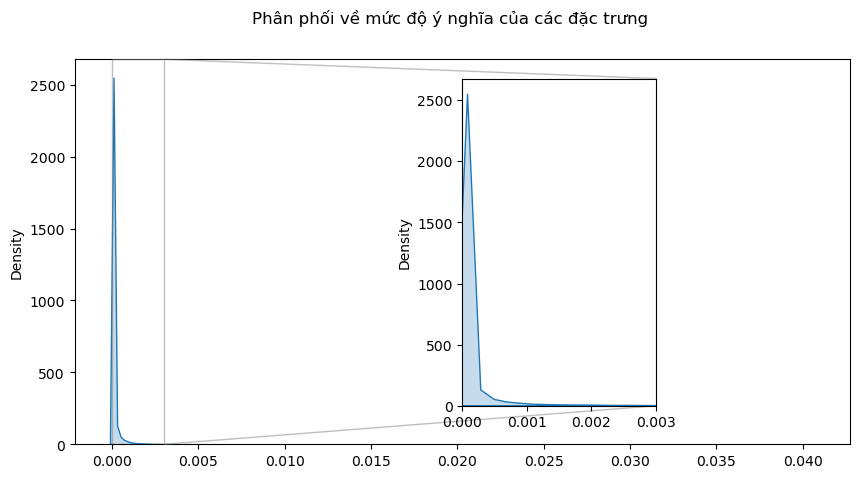

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=means_train, ax=ax, fill=True)
axin = ax.inset_axes([0.5, 0.1, 0.25, 0.85])
sns.kdeplot(data=means_train, ax=axin, fill=True)
axin.set_xlim(0., 0.003)
ax.indicate_inset_zoom(axin)
fig.suptitle('Phân phối về mức độ ý nghĩa của các đặc trưng');

Thông qua quan sát, em quyết định chọn ngưỡng là **0.001** và loại bỏ các đặc trưng có TF-IDF value trung bình dưới ngưỡng này.

In [28]:
high_value_words = labels_train[means_train > 0.001]
print('Số chiều còn lại:', len(high_value_words))

Số chiều còn lại: 2088


In [29]:
remain_words = set(high_value_words)

# Cài đặt một hàm để giảm chiều dữ liệu bằng cách chỉ giữ lại những từ quan trọng.
def dimensionality_reduction(text):
    words = text.split()
    return ' '.join(['' if word not in remain_words else word for word in words])

In [30]:
# Áp dụng chúng lên các bộ dữ liệu.
X_train = X_train.apply(dimensionality_reduction)
X_valid = X_valid.apply(dimensionality_reduction)
X_test = X_test.apply(dimensionality_reduction)

In [31]:
print(X_train.shape, X_valid.shape, X_test.shape)

(13312,) (3328,) (4160,)


### Feature Extraction

Sau khi đã sử dụng TF-IDF để loại bỏ những từ không quan trọng trong văn bản, ta sẽ vector hóa chúng thành những sequences có độ dài cố định nhằm mục đích đưa vào layer Long Short-Term Memory. Để phục vụ mục đích trên, chuyển đổi văn bản thành những chuỗi số và đưa chúng vào Embedding layer là phương pháp mà em lựa chọn.

* Xác định độ dài của mỗi sequences

Mỗi văn bản sẽ có độ dài khác nhau, việc chuẩn hóa nó về hằng số là cần thiết, để lựa chọn `sequence_length` thì ta cần quan sát dữ liệu. Bởi nếu giá trị này quá nhỏ sẽ làm thất thoát thông tin còn quá lớn thì tốn kém chi phí tính toán và overfitting.

In [32]:
data_lengths = [len(text.split()) for text in X_train]
print('Độ dài trung bình của mỗi văn bản:', np.mean(data_lengths))
print('Độ dài tối đa của mỗi văn bản:', np.max(data_lengths))

Độ dài trung bình của mỗi văn bản: 279.35787259615387
Độ dài tối đa của mỗi văn bản: 7140


Chênh lệch giữa độ dài trung bình và độ dài tối đa là một số rất lớn, chứng tỏ phân phối của nó sẽ lệch rất nặng về một phía. Để quan sát rõ hơn, em sẽ sử dụng boxplot để có cái nhìn khái quát về các quantiles.

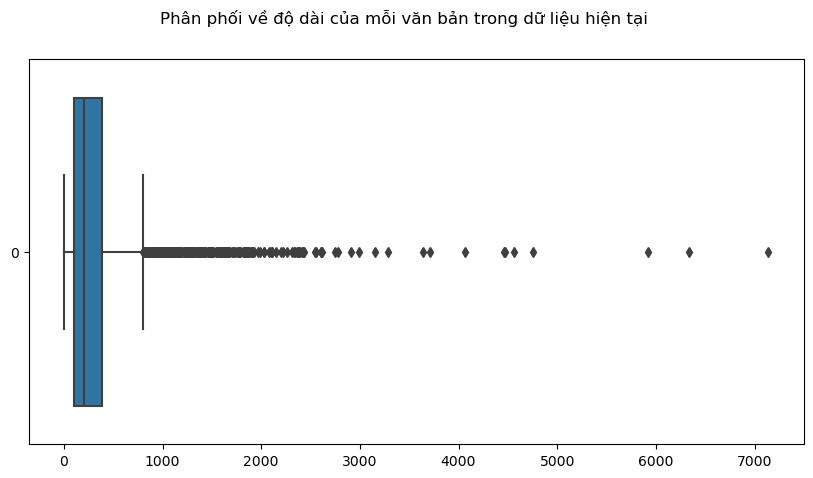

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=data_lengths, ax=ax, orient='h')
fig.suptitle("Phân phối về độ dài của mỗi văn bản trong dữ liệu hiện tại");

In [34]:
print(f"Quantitles: Q1= {np.quantile(data_lengths, 0.25)}; Q2= {np.quantile(data_lengths, 0.5)}; Q3= {np.quantile(data_lengths, 0.75)}")

Quantitles: Q1= 104.0; Q2= 209.0; Q3= 385.0


Em quyết định chọn `sequence_length` nằm giữa Q2 và Q3 là `320`, việc tiếp theo là vector hóa văn bản về độ dài trên với TextVectorization của keras.

In [35]:
from keras.layers import TextVectorization

sequence_length = 320
features_size = len(high_value_words)
vectorizer = TextVectorization(max_tokens=features_size, output_mode='int', output_sequence_length=sequence_length)
vectorizer.adapt(X_train.values)

## Building Model

Bộ dữ liệu quá lớn để có thể lưu toàn bộ vào bộ nhớ, ta cần chia nó thành những batch nhỏ bằng generator. Trong các generator này, em sẽ lấy ngẫu nhiên một số phần tử bằng với kích thước batch để đưa vào mô hình.

In [36]:
# Cài đặt một batch generator
def batch_generator(X, y, batch_size=32):
    data_size = len(y)
    X_batch = np.empty((batch_size, sequence_length), dtype=np.int32)
    y_batch = np.empty((batch_size))
    indexs = np.empty((batch_size), dtype=np.int32)
    while True:
        try:
            indexs[:] = np.random.randint(0, data_size, size=batch_size)
            X_batch[:] = vectorizer(X[indexs])
            y_batch[:] = y[indexs]
            yield X_batch, y_batch
        except:
            continue

X_train_ = X_train.values
y_train_ = y_train.values
X_valid_ = X_valid.values
y_valid_ = y_valid.values

train_gen = batch_generator(X_train_, y_train_, batch_size=64)
valid_gen = batch_generator(X_valid_, y_valid_, batch_size=64)

#### Mô tả mô hình:

Sức mạnh của LSTM để xử lý ngôn ngữ tự nhiên đã được chứng minh qua nhiều mô hình. Khi kết hợp với CNN để trích xuất những đặc trưng ẩn từ văn bản hứa hẹn sẽ tăng cường hiệu quả của LSTM lên nhiều.<br><br>
&emsp;**Mô hình hybrid CNN-LSTM** có ý tưởng chính là sử dụng lớp tích chập 1D để `trích xuất đặc trưng từ văn bản` (là những sequences) rồi đưa vào lớp Long short-term memory để phân tích ý nghĩa của chúng [2]. 

In [37]:

class CNN_LSTM(tf.keras.Model):
    
    def __init__(self, **kwargs):
        super(CNN_LSTM, self).__init__(**kwargs)
        self.Embedding = tf.keras.layers.Embedding(input_dim=features_size, output_dim=100, input_length=sequence_length)
        self.Conv_1   = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', data_format='channels_last')
        self.Drop_out = tf.keras.layers.Dropout(0.2)
        self.Pool_1     = tf.keras.layers.MaxPooling1D(pool_size=4)
        self.LSTM_out = tf.keras.layers.LSTM(100)
        
        self.Outputs  = tf.keras.layers.Dense(1, activation='sigmoid')

    
    def call(self, inputs):
        x = inputs
        x = self.Embedding(x)
        x = self.Conv_1(x)
        x = self.Drop_out(x)
        x = self.Pool_1(x)
        x = self.LSTM_out(x)
        return self.Outputs(x)
        
    def summary(self):
        x = tf.keras.layers.Input(shape=(sequence_length))
        dummy_model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        dummy_model.summary()

model = CNN_LSTM()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320)]             0         
                                                                 
 embedding (Embedding)       (None, 320, 100)          208800    
                                                                 
 conv1d (Conv1D)             (None, 318, 64)           19264     
                                                                 
 dropout (Dropout)           (None, 318, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 79, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                             

In [38]:
# Cài đặt một hàm callback để lưu trữ giá trị của các metrics và in tiến trình ở cuối mỗi epochs.
import sys
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        super(CustomCallback, self).__init__()
        self.epochs = epochs

        self.values = {'loss' : [], 'accuracy' : [], 'precision' : [], 'recall' : [],
                      'val_loss' : [], 'val_accuracy' : [], 'val_precision' : [], 'val_recall' : []}
        
    def on_epoch_end(self, epoch, logs=None):
        for metric_name, metric_value in logs.items():
            self.values[metric_name].append(metric_value)

        NumOfEpochs = self.epochs
        completed = 60*(epoch+1)//NumOfEpochs
        incompleted = 60 - completed
        
        sys.stdout.write(f"\r[{'='*completed}>{'-'*incompleted}] {100*(epoch+1)//NumOfEpochs}% ")
        sys.stdout.write(f"| epoch [{(epoch+1)}/{NumOfEpochs}] :")
        for key in self.values:
            sys.stdout.write(f"{key}: {np.round(self.values[key][-1], 4)}  ")
        sys.stdout.flush()


In [39]:
NumOfEpochs = 20
precision = Precision()
recall = Recall()

In [40]:
model.compile( optimizer= 'adam',loss='binary_crossentropy', metrics=['accuracy', precision, recall])
my_callbacks = CustomCallback(epochs=NumOfEpochs)
model.fit(train_gen,
          validation_data=valid_gen, 
          steps_per_epoch=150,
          validation_steps=100,
          epochs=NumOfEpochs,
          callbacks = [my_callbacks],
          verbose = 0
         )

[============================================================>] 100% | epoch [20/20] :loss: 0.0117  accuracy: 0.9972  precision: 0.998  recall: 0.9965  val_loss: 0.119  val_accuracy: 0.9747  val_precision: 0.9693  val_recall: 0.9792   

### Resulting

#### Biểu diễn kết quả của quá trình huấn luyện.

In [41]:
performance = my_callbacks.values
performance = pd.DataFrame(performance)

In [42]:
performance['epoch'] = range(1, 21)
performance['epoch'] = performance['epoch'].astype('str')

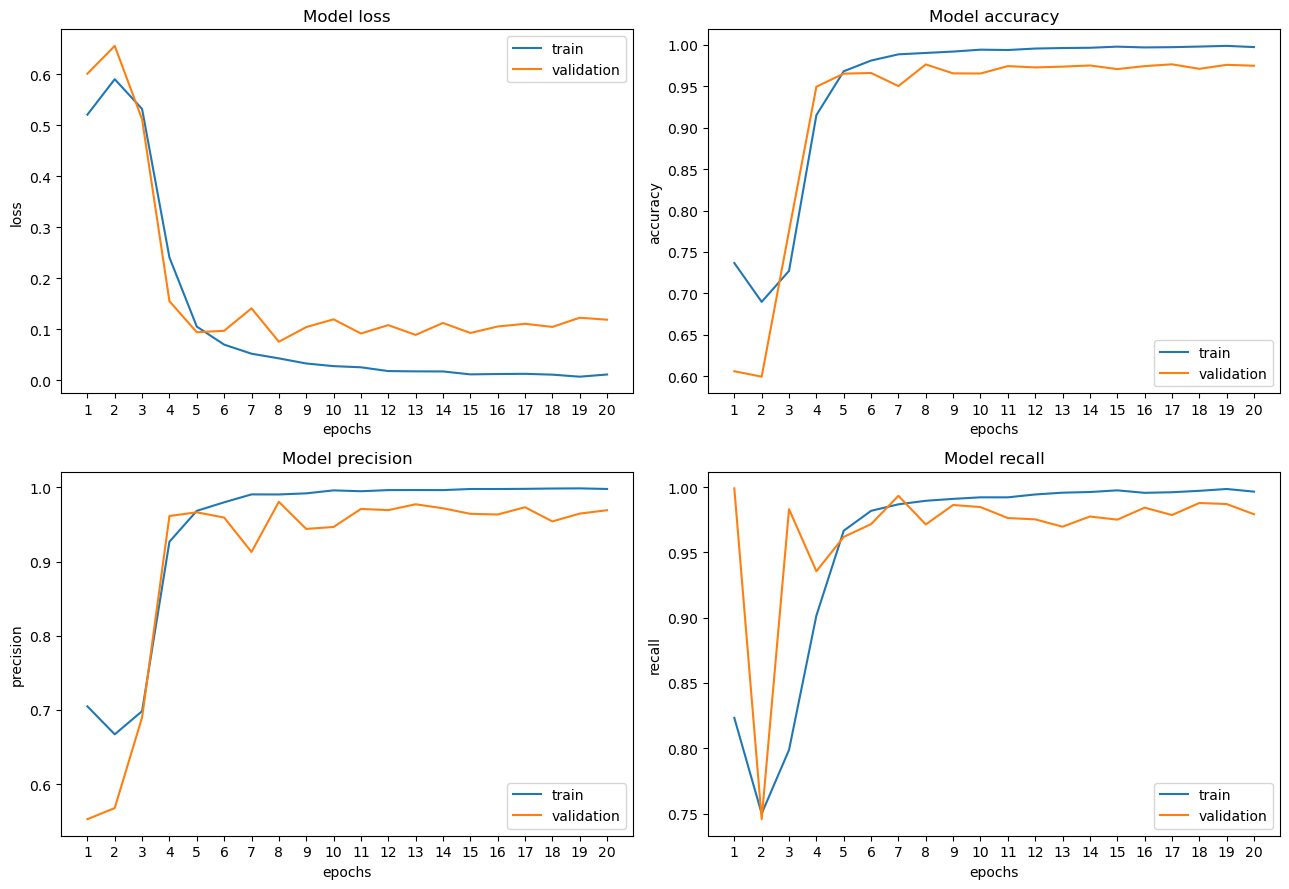

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(13, 9))
cols = [['loss', 'val_loss'], ['accuracy', 'val_accuracy'], ['precision', 'val_precision'], ['recall', 'val_recall']]

for i in [0, 1]:
    for j in [0, 1]:
        sns.lineplot(data=performance, x = 'epoch', y = cols[i*2+j][0], ax=ax[i,j], label='train')
        sns.lineplot(data=performance, x = 'epoch', y = cols[i*2+j][1], ax=ax[i,j], label='validation')
        ax[i, j].set_xlabel("epochs")
        ax[i, j].set_ylabel(cols[i*2+j][0])
        ax[i, j].set_title(f"Model {cols[i*2+j][0]}")
        ax[i, j].legend();
fig.tight_layout()

&rarr; *Các độ đo có giá trị biến động nhiều ở 10 epoch đầu. Khi số epoch tăng lên, chúng đều hội tụ về một khoảng khá tốt.*

#### Đánh giá kết quả trên tập test.

In [44]:
def test_generator(X, y):
    data_size = len(y)
    X_batch = np.empty((1, sequence_length), dtype=np.int32)
    y_batch = np.empty((1), dtype=np.int32)
    index = 0
    while True:
        try:
            X_batch[0] = vectorizer(X[index])
            y_batch[0] = y[index]
            yield X_batch, y_batch
        except:
            X_batch[0] = vectorizer(X[index-1])
            y_batch[0] = y[index-1]
            yield X_batch, y_batch
        index += 1

In [45]:
test_gen = test_generator(X_test.values, y_test.values)

Thực hiện dự đoán trên toàn bộ test set.

In [46]:
scores = model.evaluate(
    test_gen,
    steps=X_test.shape[0]
    )

4160/4160 [==============================] - 105s 25ms/step - loss: 0.1222 - accuracy: 0.9750 - precision: 0.9684 - recall: 0.9823


In [47]:
dict_scores = dict(zip(model.metrics_names, scores))

for score in dict_scores:
    print(score,':',round(dict_scores[score], 5),end='\n---------------------\n')

loss : 0.12217
---------------------
accuracy : 0.975
---------------------
precision : 0.96843
---------------------
recall : 0.98231
---------------------


So sánh loss trên từng tập hợp khác nhau.

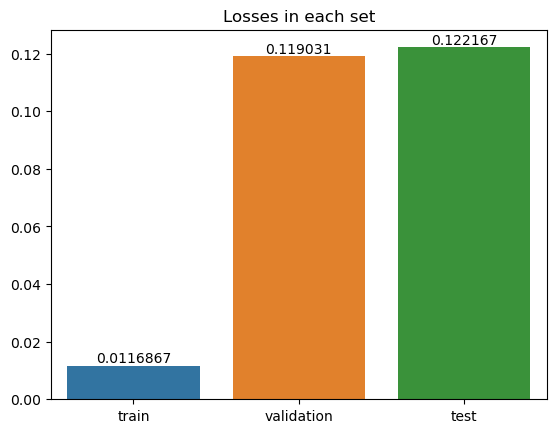

In [48]:
labels = np.array(['train', 'validation', 'test'])
losses = np.array([performance['loss'].iloc[-1], performance['val_loss'].iloc[-1], dict_scores.get('loss')])

ax = sns.barplot(x=labels, y=losses)
ax.set_title('Losses in each set')
for i in ax.containers:
    ax.bar_label(i,)

&rarr; Có sự chênh lệch không quá đáng kể (`khoảng 0.1`) giữa loss của train set với validation/test set.<br>

In [49]:
tags = ['accuracy', 'precision', 'recall']

metrics_values = {'train' : [performance[tags[0]].iloc[-1], performance[tags[1]].iloc[-1], performance[tags[2]].iloc[-1]],
                'validation' : [performance['val_'+tags[0]].iloc[-1], performance['val_'+tags[1]].iloc[-1], performance['val_'+tags[2]].iloc[-1]],
                'test' : [dict_scores.get(tags[0]), dict_scores.get(tags[1]), dict_scores.get(tags[2])],
                'metric' : tags}
metrics_v = pd.DataFrame(metrics_values)
data_to_plot = metrics_v.melt(id_vars='metric', var_name='dataset', value_name='score')

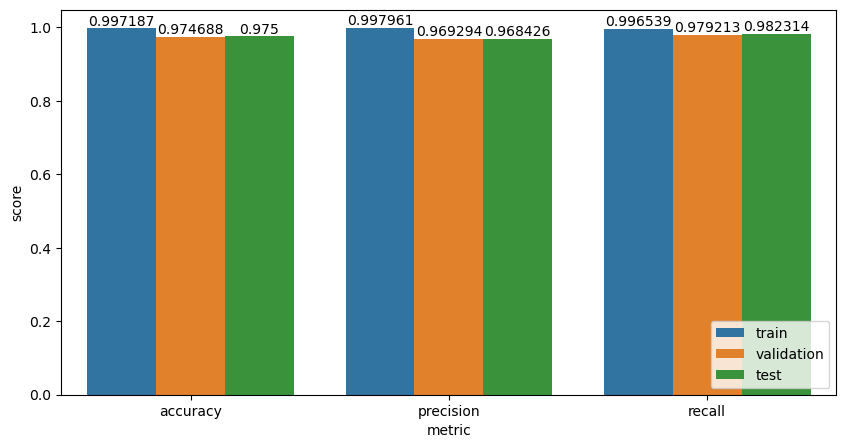

In [53]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=data_to_plot, x= 'metric', y='score', hue='dataset')
ax.legend(loc='lower right')
for i in ax.containers:
    ax.bar_label(i,)

**&rarr; Mô hình thu được điểm số khá cao ở tất cả độ đo (dao động ở khoảng `97.5%`) chứng minh khả năng mạnh mẽ và đáng tin cậy nó. Đây là cơ sở cho việc phát triển thêm và áp dụng mô hình cho những dữ liệu thực tế trong tương lai.**

### Tài liệu tham khảo:

1. Q. Liu, J. Wang, D. Zhang, Y. Yang and N. Wang, "Text Features Extraction based on TF-IDF Associating Semantic," 2018 IEEE 4th International Conference on Computer and Communications (ICCC), Chengdu, China, 2018, pp. 2338-2343, doi: 10.1109/CompComm.2018.8780663.
2. K. L. Tan, C. Poo Lee and K. M. Lim, "Fake News Detection with Hybrid CNN-LSTM," 2021 9th International Conference on Information and Communication Technology (ICoICT), Yogyakarta, Indonesia, 2021, pp. 606-610, doi: 10.1109/ICoICT52021.2021.9527469.